# MLP Example

This Demo file will take you thorugh all the steps involved in predicting a tags value by using the values of other tags in the data source.

We'll use the sci-kit learn implementation of a Multi-layer perceptron (MLP) which is a simple neural network.

In this example the demo data source "IP Datasource 2" will be used as an example so make sure you have it authorised.

Set up the Intelligent Plant clients.

In [1]:
import json

import intelligent_plant.session_manager as session_manager
import intelligent_plant.utility as utility

# Remeber to enable the device code flow in the app store app registration

#load the json config file with the app information
with open('config.json') as json_config_file:
    config = json.load(json_config_file)

    app_id = config['app']['id']
    app_secret = config['app']['secret']
    base_url = config['app_store']['base_url']


app_store = session_manager.load_session_or_login(app_id, app_secret, scopes=['DataRead'], base_url=base_url)

data_core = app_store.get_data_core_client()

In [2]:
import intelligent_plant.utility as utility
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Look up the fully qualified names of authorised data sources.

Check that 'Oil Co Demo' appears in this list for you.

In [3]:
list(map(lambda x: x['Name']['QualifiedName'], data_core.get_data_sources()))

['FCBB05262EADC0B147746EE6DFB2B3EA5C272C33C2C5E3FE8F473D85529461CA.Alarm Analysis Demo',
 'FCBB05262EADC0B147746EE6DFB2B3EA5C272C33C2C5E3FE8F473D85529461CA.Oil Co Demo']

We'll query all of the tags in Oil Co Demo and make a list of just their names

In [4]:
dsn = 'FCBB05262EADC0B147746EE6DFB2B3EA5C272C33C2C5E3FE8F473D85529461CA.Oil Co Demo'

This code will page through every tag on the datasource and add it to a list. Note: on a real data source this would be a very expensive operation and is not advised. A much better approach would be to only query tags relevant to the problem you are trying to solve.

In [5]:
tags = []

page_size = 50
page_num = 1
while True:
    page = data_core.get_tags(dsn, page_num, page_size)
    
    #append the page just fetched into the list of all tags
    tags += page
    
    page_num += 1
    
    #if a page is shorter than the page size requested it is the last page
    if (len(page) < page_size):
        break

#map tages meta data to only be tag name and filter out the "TIME" tag
tag_names = list(filter(lambda x: x != "TIME", map(lambda x: x["Id"], tags)))

Fetch 10 days of data for the selected tags with a point every 1 hour. Data will be interpolated.

In [6]:
all_data = data_core.get_processed_data({dsn: tag_names}, "*-10d", "*", "1h", "interp")

Convert the returned data into a data frame to make it easier to work with

In [7]:
all_data_frame = utility.query_result_to_data_frame(all_data, force_numeric=True)

Some values may be NaN, we can drop rows where this is true:

In [8]:
all_data_frame = all_data_frame.dropna()

We can plot the contents of a data frame easily

<Axes: >

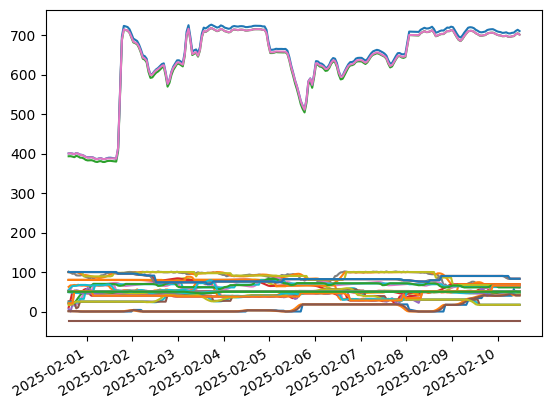

In [9]:
all_data_frame.plot(legend=False)

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

Set up a processing pipe. This encapsulates scaling and the MLP into the same pipe and allows us to train and test them all at once.

In [11]:
pipe = make_pipeline(StandardScaler(), MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,), activation='logistic'))

Randomly split the data into training and testing.

We will try to predict the value of the last tag "WI Pump D_Suct_PI" by using the values of all the other tags.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(all_data_frame[all_data_frame.columns[:-1]], all_data_frame[all_data_frame.columns[-1]])

The MLP is going to try and learn the relationship between the graph above and below

Use the training data to train the model.

In [13]:
pipe.fit(X_train, y_train)

c:\dev\py-app-store-api\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', alpha=1e-05,
                              solver='lbfgs'))])

In [14]:
prediction = pipe.predict(X_test)

In [15]:
prediction_df = pd.DataFrame({ "actual": y_test, "prediction": prediction }).reset_index(drop=True)

We can use seaborn to generate a scatter plot of the models prediction against the known ground truth.

Ideally, a perfect result would create a straight line of x = y. Any deviation from that line is error in the model.

<Axes: xlabel='actual', ylabel='prediction'>

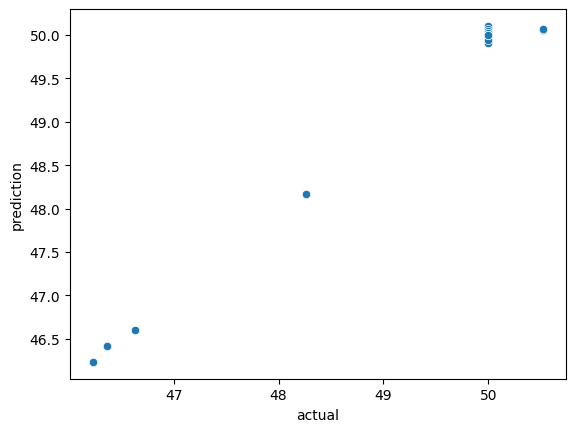

In [16]:
sns.scatterplot(x=prediction_df['actual'], y=prediction_df['prediction'])

The score function can be used to detemine the coefficient of determination (R^2) of our model. A score of 1 means that the prediction is perfect.

In [17]:
pipe.score(X_test, y_test)

0.9873689663697222

In [18]:
from sklearn.metrics import *

Other metrics can also be calculated. Such as the mean absoulte error. In this case 0 would be perfect.

In [19]:
mean_absolute_error(y_test, prediction)

0.04056262405256543